# Air transportation Ocurrences
## Summary Analysis 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../scripts")

In [4]:
from data_loader import load_data_from_csv, load_data_from_results
from common.export_csv import exportDataVersion
from common.export_result import export_csv_result
from common.export_temp_csv import export_csv_temp

In [5]:
df = load_data_from_csv('fullData_V2.csv')
#Data length
print(f"# of rows 'fullData_V2.csv': {len(df)}")

# of rows 'fullData_V2.csv': 47781


## Preprocessing

In [7]:
#Delete the rows without Summary
df = df.dropna(subset=['Summary']).reset_index(drop=True)

In [8]:
print(df['Summary'].head(10))

0    C-IICE a privately operated Quad City Challeng...
1    C-GWCP a Piper PA-32-300 aircraft operated by ...
2    C-FKCK an Airbus 320-200 aircraft operated by ...
3    C-GJVC a Fairchild SA227-DC aircraft operated ...
4    C-GGSV an Aerospatiale AS 350 B-2 aircraft ope...
5    N12028 an Airbus 319-100 aircraft operated by ...
6    C-GGCT a privately operated Cessna 182M aircra...
7    N910XJ a Bombardier CL-600-2D24 (CRJ 900) airc...
8    N174DZ a Boeing 767-300 aircraft operated by D...
9    C-FBIY a Cessna 182F aircraft operated by Skyd...
Name: Summary, dtype: object


### Deleting the first word
First word is a code, is not apporting value 

In [10]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import download

Download necessary libaries

In [12]:
# import nltk
# import os

# # Define the path to download nltk data inside the venv
# nltk_data_path = os.path.join(os.getcwd(), "venv", "nltk_data")
# nltk.download('punkt', download_dir=nltk_data_path)
# nltk.download('stopwords', download_dir=nltk_data_path)
# nltk.download('punkt_tab')
# download('stopwords')  # Stopwords list
# download('punkt')      # Tokenizer
# nltk.download('punkt')
# print("NLTK data downloaded to:", nltk_data_path)

In [13]:
#Ensuring there are no spaces initially and in the end
df['Summary'] = df['Summary'].str.strip()

#Deleting the first word
df['Summary'] = df['Summary'].apply(lambda x: ' '.join(x.split(' ')[1:]) if isinstance(x, str) else x)

print(df['Summary'].head(10))

0    a privately operated Quad City Challenger II S...
1    a Piper PA-32-300 aircraft operated by MHA Ent...
2    an Airbus 320-200 aircraft operated by Air Can...
3    a Fairchild SA227-DC aircraft operated by Bear...
4    an Aerospatiale AS 350 B-2 aircraft operated b...
5    an Airbus 319-100 aircraft operated by America...
6    a privately operated Cessna 182M aircraft was ...
7    a Bombardier CL-600-2D24 (CRJ 900) aircraft op...
8    a Boeing 767-300 aircraft operated by Delta Ai...
9    a Cessna 182F aircraft operated by Skydive Man...
Name: Summary, dtype: object


In [14]:
#Preprocessing function
def preprocess_text(text):
    if pd.isnull(text):  # Handle null values
        return ""
    
    #Convert text to lowercase
    text = text.lower()
    
    #Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    #Remove numbers
    text = re.sub(r'\d+', '', text)
    
    #Tokenize the text into individual words
    words = word_tokenize(text)
    
    #Remove stopwords (common words like "a", "the", "is")
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    #Apply stemming (reduce words to their root form)
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    #Rejoin words into a single string and remove extra whitespace
    text = ' '.join(words).strip()
    
    return text

In [15]:
#Applying preprocessing to the "Summary" column
#df['Processed_Summary'] = df['Summary'].apply(preprocess_text)
#export_csv_result(df, "fullData_V2_summary_preprocessed")

In [16]:
df = load_data_from_results("fullData_V2_summary_preprocessed.csv")
#Data length
print(f"# of rows 'fullData_V2.csv': {len(df)}")

# of rows 'fullData_V2.csv': 47684


In [17]:
#Printing the DataFrame to see the results
print(df['Processed_Summary'].head(10))

0    privat oper quad citi challeng ii special adva...
1    piper pa aircraft oper mha enterpris conduct v...
2    airbu aircraft oper air canada conduct flight ...
3    fairchild sadc aircraft oper bearskin lake air...
4    aerospatial b aircraft oper great slave helico...
5    airbu aircraft oper american airlin conduct fl...
6    privat oper cessna aircraft conduct flight dir...
7    bombardi cld crj aircraft oper endeavour air c...
8    boe aircraft oper delta airlin conduct flight ...
9    cessna f aircraft oper skydiv manitoba conduct...
Name: Processed_Summary, dtype: object


### Frequency document-term matrix and word clouds

In [19]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
def get_words_frequencies(df_param):
    #Creating a document-term matrix
    vectorizer = CountVectorizer()
    dtm = vectorizer.fit_transform(df_param['Processed_Summary'])
    
    #Suming up the word counts
    word_counts = dtm.toarray().sum(axis=0)
    word_frequencies = pd.DataFrame({
        "word": vectorizer.get_feature_names_out(),
        "frequency": word_counts
    }).sort_values(by="frequency", ascending=False)

    return word_frequencies

In [21]:
def plotWordCloud(word_frequencies_param):
    #Converting the word_frequencies DataFrame to a dictionary
    word_frequencies_dict = dict(zip(word_frequencies_param["word"], word_frequencies_param["frequency"]))
    
    #Generating the Word Cloud
    wordcloud = WordCloud(
        width=800,               # Width of the Word Cloud image
        height=400,              # Height of the Word Cloud image
        background_color="white", # Background color
        colormap="viridis",      # Color palette
        max_words=200            # Maximum number of words to display
    ).generate_from_frequencies(word_frequencies_dict)
    
    #Plotting the Word Cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")  # Turn off axis
    plt.title("Word Cloud of Processed Summary", fontsize=16)
    plt.show()

#### For accidents

In [23]:
#Getting only accidents
df_filtered_accidents = df[df["OccTypeID_DisplayEng"] == "ACCIDENT"]

word_frequencies_accidents = get_words_frequencies(df_filtered_accidents)
#export_csv_result(word_frequencies_accidents, "Summary_word_frecuencies_ACCIDENTS")

#Display the first 10 rows
print(word_frequencies_accidents.head(10))

           word  frequency
510    aircraft      50648
19838     pilot      42471
15870      land      24824
12121    flight      14708
11106     engin      14051
21947    runway      13115
16070      left      10984
12861      gear       9962
21599     right       9718
9633      damag       9167


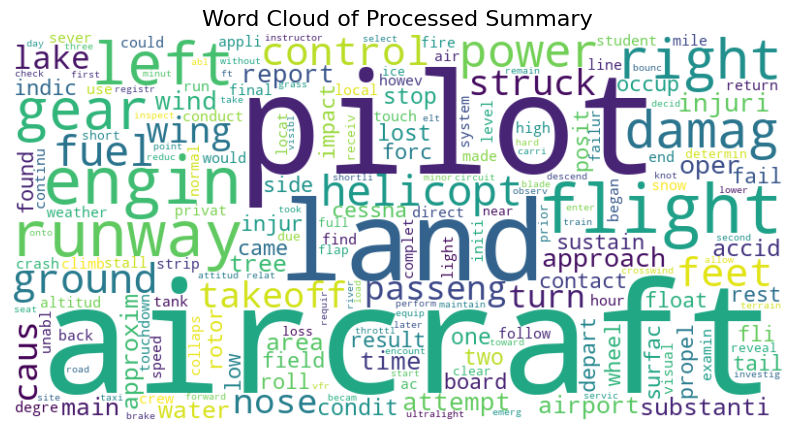

In [24]:
plotWordCloud(word_frequencies_accidents)

#### For incidents

In [26]:
#Filtering the DataFrame to keep only INCIDENT rows and drop NaN values in 'Processed_Summary'
df_filtered_incidents = df[df["OccTypeID_DisplayEng"] == "INCIDENT"].dropna(subset=['Processed_Summary'])

word_frequencies_incidents = get_words_frequencies(df_filtered_incidents)
#Exporting results
#export_csv_result(word_frequencies_incidents, "Summary_word_frequencies_INCIDENTS")

# Display the first few rows
print(word_frequencies_incidents.head(10))

           word  frequency
640    aircraft      43862
12623    flight      42013
8538       crew      32486
16841      land      25072
11360     engin      18379
20564      oper      17745
24176    runway      12920
607         air      12706
23721    return      11999
18048   mainten      10637


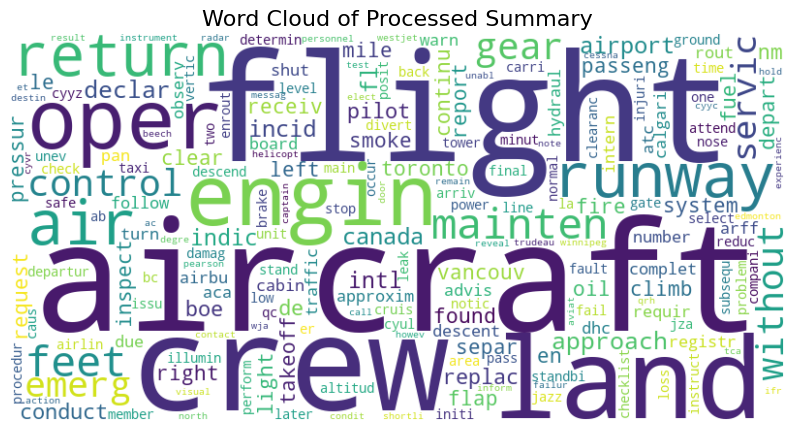

In [27]:
plotWordCloud(word_frequencies_incidents)

## Classification Model

In [42]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Function to preprocess and cluster data using TF-IDF + K-Means
def tfidf_kmeans_clustering(df, text_column):
    # Step 1: Convert text into TF-IDF vectors
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df[text_column])
    
    # Step 2: Use the Elbow Method to find the optimal number of clusters
    distortions = []
    silhouette_scores = []
    K = range(2, 10)  # You can change this range based on your needs
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(tfidf_matrix)
        distortions.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(tfidf_matrix, kmeans.labels_))

    # Plotting the elbow curve
    plt.figure(figsize=(12, 6))
    plt.plot(K, distortions, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.show()

    # Plotting silhouette scores
    plt.figure(figsize=(12, 6))
    plt.plot(K, silhouette_scores, marker='o')
    plt.title('Silhouette Scores for K')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

    # Step 3: Apply K-Means with the optimal number of clusters (manually choose or auto)
    optimal_k = int(input("Enter the number of clusters (optimal K): "))
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df.loc[:, 'KMeansCluster'] = kmeans.fit_predict(tfidf_matrix)

    return df


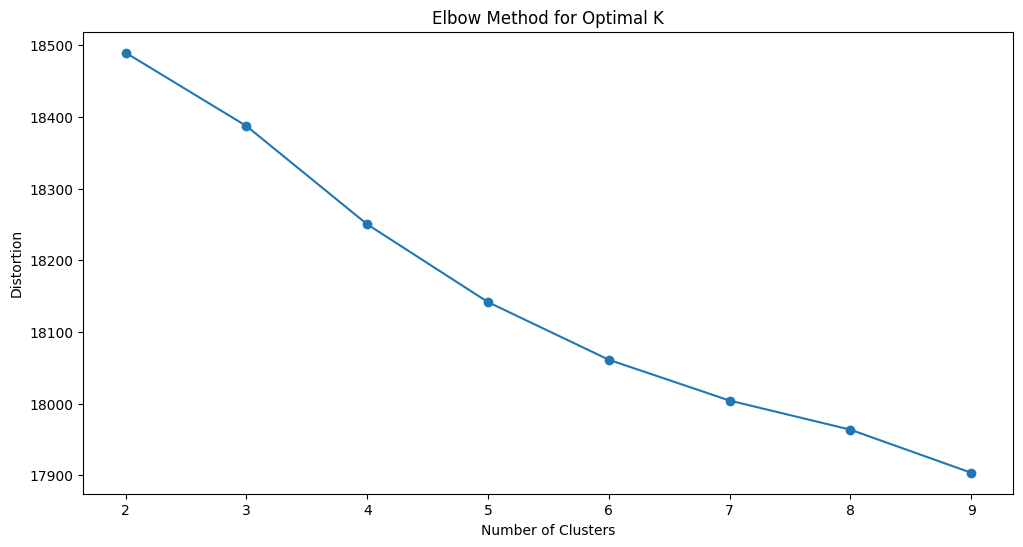

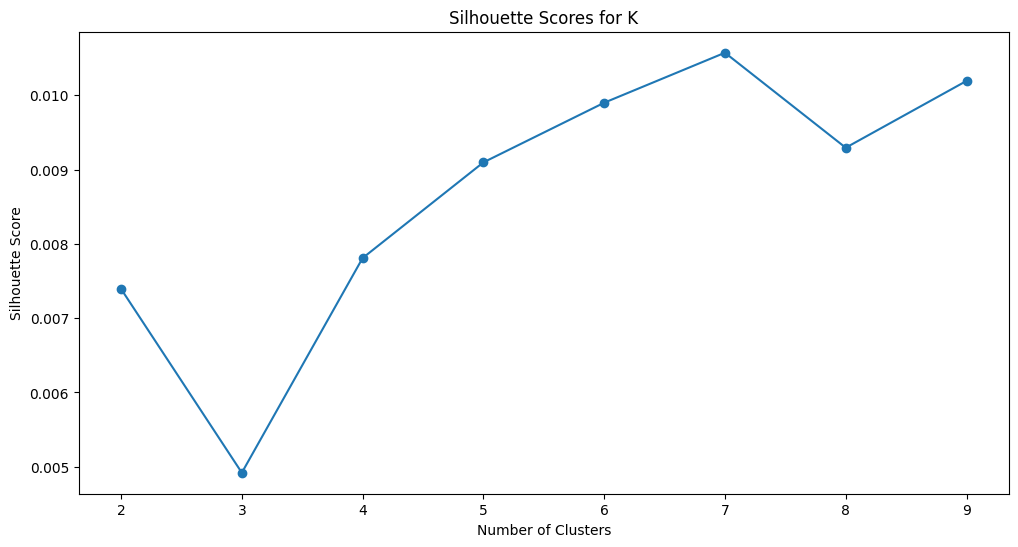

Enter the number of clusters (optimal K):  4


C:\Users\camii\AppData\Local\Temp\ipykernel_12920\372281090.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['KMeansCluster'] = kmeans.fit_predict(tfidf_matrix)


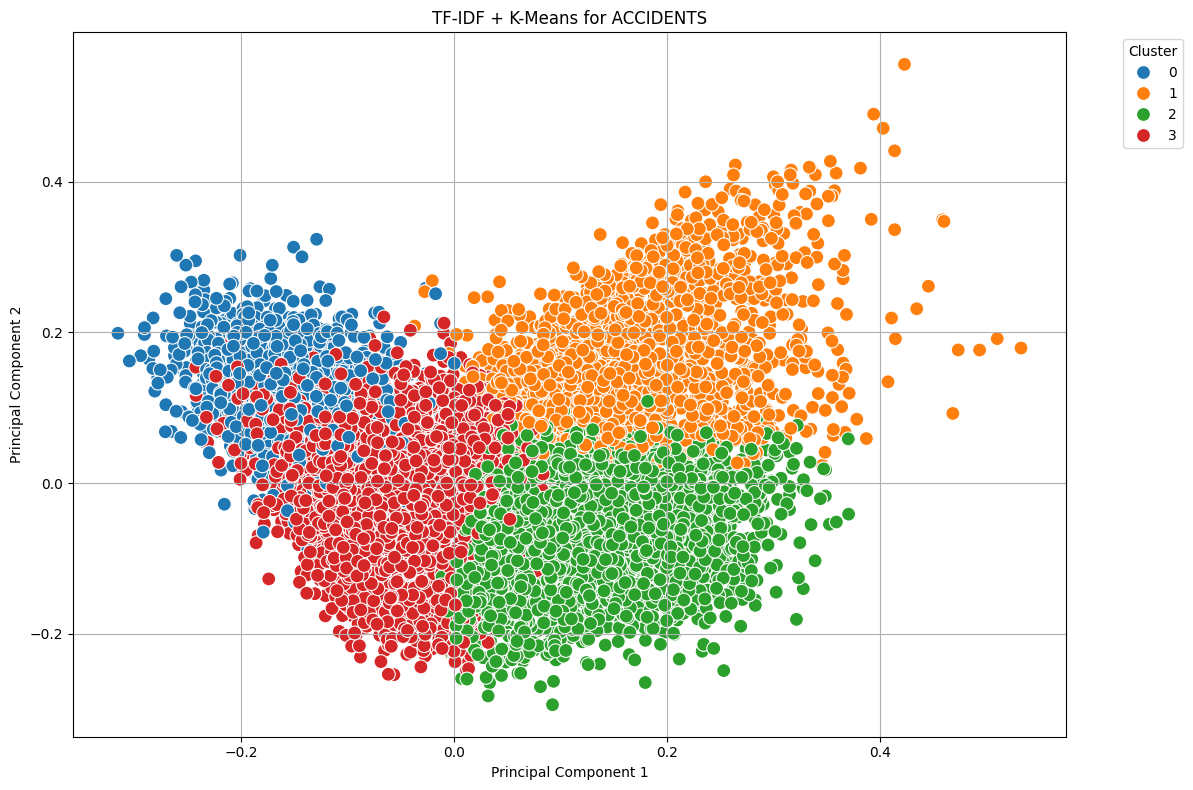

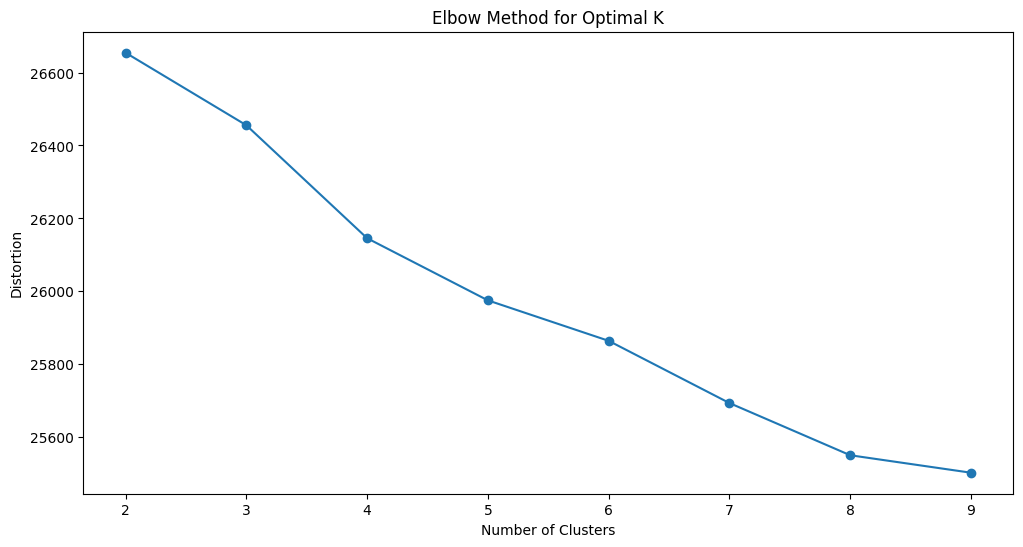

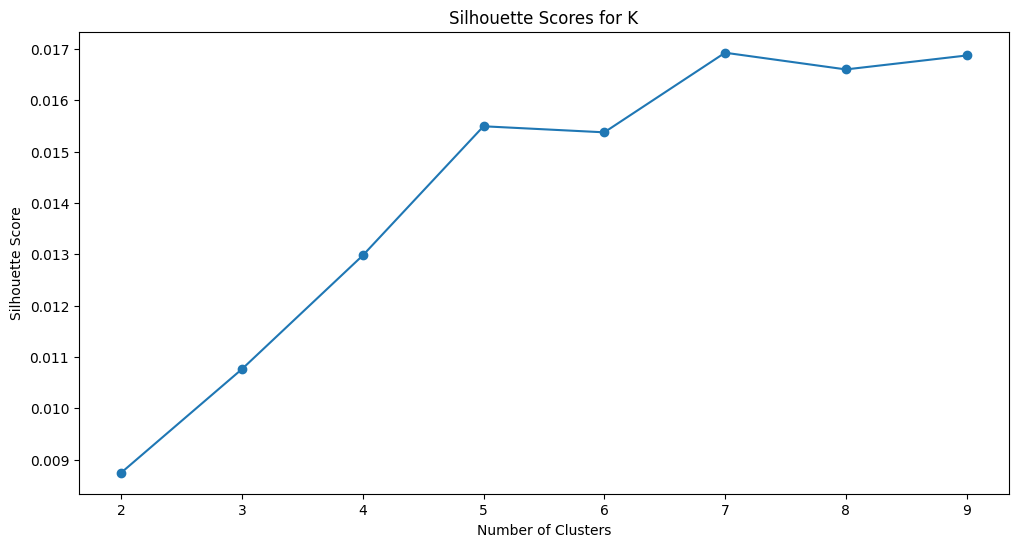

Enter the number of clusters (optimal K):  4


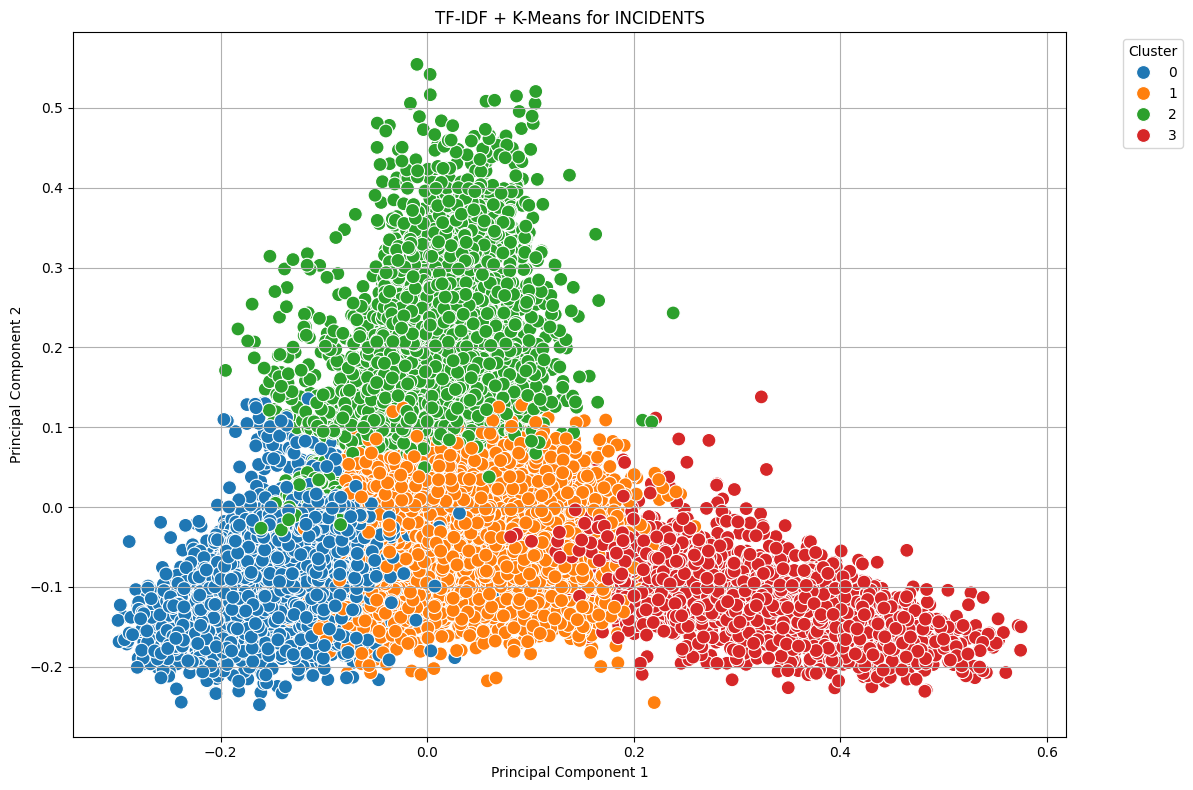

In [44]:
from sklearn.decomposition import PCA
import seaborn as sns

def visualize_kmeans_clusters(df, tfidf_matrix, title="TF-IDF + K-Means Clustering"):
    # Reduce dimensions to 2D using PCA
    pca = PCA(n_components=2, random_state=42)
    reduced_data = pca.fit_transform(tfidf_matrix.toarray())

    # Create a DataFrame for visualization
    vis_df = pd.DataFrame({
        "PCA1": reduced_data[:, 0],
        "PCA2": reduced_data[:, 1],
        "Cluster": df["KMeansCluster"]
    })

    # Plot the clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=vis_df, x="PCA1", y="PCA2", hue="Cluster", palette="tab10", s=100)
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Apply to ACCIDENTS
df_filtered_accidents = tfidf_kmeans_clustering(df_filtered_accidents, "Processed_Summary")
visualize_kmeans_clusters(df_filtered_accidents, 
                          TfidfVectorizer(stop_words='english').fit_transform(df_filtered_accidents["Processed_Summary"]),
                          "TF-IDF + K-Means for ACCIDENTS")

#Apply to INCIDENTS
df_filtered_incidents = tfidf_kmeans_clustering(df_filtered_incidents, "Processed_Summary")
visualize_kmeans_clusters(df_filtered_incidents, 
                          TfidfVectorizer(stop_words='english').fit_transform(df_filtered_incidents["Processed_Summary"]),
                           "TF-IDF + K-Means for INCIDENTS")


In [48]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Function to preprocess and cluster data using Word Embeddings + DBSCAN
def word_embeddings_dbscan_clustering(df, text_column, eps=0.5, min_samples=5):
    # Step 1: Generate word embeddings using a pre-trained model (e.g., BERT or SentenceTransformer)
    model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight transformer model
    embeddings = model.encode(df[text_column].tolist())
    
    # Step 2: Cluster using DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
    labels = dbscan.fit_predict(embeddings)
    df['DBSCANCluster'] = labels

    # Step 3: Handle outliers
    outliers = df[df['DBSCANCluster'] == -1]
    print(f"Number of outliers: {len(outliers)}")

    return df



In [50]:
from sklearn.manifold import TSNE

def visualize_dbscan_clusters(df, embeddings, title="Word Embeddings + DBSCAN Clustering"):
    # Reduce dimensions to 2D using t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_data = tsne.fit_transform(embeddings)

    # Create a DataFrame for visualization
    vis_df = pd.DataFrame({
        "TSNE1": reduced_data[:, 0],
        "TSNE2": reduced_data[:, 1],
        "Cluster": df["DBSCANCluster"]
    })

    # Plot the clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=vis_df, x="TSNE1", y="TSNE2", hue="Cluster", palette="tab10", s=100)
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Apply to ACCIDENTS
df_filtered_accidents = word_embeddings_dbscan_clustering(df_filtered_accidents, "Processed_Summary", eps=0.5, min_samples=5)
embeddings_accidents = SentenceTransformer('all-MiniLM-L6-v2').encode(df_filtered_accidents["Processed_Summary"].tolist())
visualize_dbscan_clusters(df_filtered_accidents, embeddings_accidents, "Word Embeddings + DBSCAN for ACCIDENTS")

# Apply to INCIDENTS
df_filtered_incidents = word_embeddings_dbscan_clustering(df_filtered_incidents, "Processed_Summary", eps=0.5, min_samples=5)
embeddings_incidents = SentenceTransformer('all-MiniLM-L6-v2').encode(df_filtered_incidents["Processed_Summary"].tolist())
visualize_dbscan_clusters(df_filtered_incidents, embeddings_incidents, "Word Embeddings + DBSCAN for INCIDENTS")



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\camii\Documents\U\Term 1\Term 1\Data Analytics\Project\Airplane_Accidents_Analytics\venv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\camii\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Function to preprocess and cluster data using Word Embeddings + DBSCAN
def word_embeddings_dbscan_clustering(df, text_column, model, eps=0.5, min_samples=5):
    """
    Function to generate embeddings and apply DBSCAN clustering.

    Parameters:
    df: DataFrame
    text_column: Name of the column with text data
    model: Pre-trained SentenceTransformer model
    eps: DBSCAN epsilon parameter
    min_samples: DBSCAN min_samples parameter

    Returns:
    df with DBSCANCluster column
    embeddings: The generated embeddings
    """
    # Step 1: Generate word embeddings using the pre-trained model
    embeddings = model.encode(df[text_column].tolist(), batch_size=64, show_progress_bar=True)

    # Step 2: Cluster using DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
    labels = dbscan.fit_predict(embeddings)
    df['DBSCANCluster'] = labels

    # Step 3: Handle outliers
    outliers = df[df['DBSCANCluster'] == -1]
    print(f"Number of outliers: {len(outliers)}")

    return df, embeddings


# Visualization function with PCA
def visualize_dbscan_clusters(df, embeddings, title="Word Embeddings + DBSCAN Clustering"):
    """
    Function to visualize DBSCAN clusters using PCA.

    Parameters:
    df: DataFrame with clusters
    embeddings: Word embeddings for visualization
    title: Title of the plot
    """
    # Reduce dimensions to 2D using PCA
    pca = PCA(n_components=2, random_state=42)
    reduced_data = pca.fit_transform(embeddings)

    # Create a DataFrame for visualization
    vis_df = pd.DataFrame({
        "PCA1": reduced_data[:, 0],
        "PCA2": reduced_data[:, 1],
        "Cluster": df["DBSCANCluster"]
    })

    # Plot the clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=vis_df, x="PCA1", y="PCA2", hue="Cluster", palette="tab10", s=100)
    plt.title(title)
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Main script
# Load the pre-trained SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2', device="cuda" if torch.cuda.is_available() else "cpu")

# Apply to ACCIDENTS
df_filtered_accidents, embeddings_accidents = word_embeddings_dbscan_clustering(
    df_filtered_accidents, "Processed_Summary", model, eps=0.5, min_samples=5
)
visualize_dbscan_clusters(df_filtered_accidents, embeddings_accidents, "Word Embeddings + DBSCAN for ACCIDENTS")

# Apply to INCIDENTS
df_filtered_incidents, embeddings_incidents = word_embeddings_dbscan_clustering(
    df_filtered_incidents, "Processed_Summary", model, eps=0.5, min_samples=5
)
visualize_dbscan_clusters(df_filtered_incidents, embeddings_incidents, "Word Embeddings + DBSCAN for INCIDENTS")


Batches:   0%|          | 0/307 [00:00<?, ?it/s]